In [1]:
#Data Loading

import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import joblib
import os


In [2]:
# Fetch data from API
url = "https://disease.sh/v3/covid-19/historical/India?lastdays=all"
data = requests.get(url).json()

cases = data["timeline"]["cases"]

# Create DataFrame
df_cases = pd.DataFrame(list(cases.items()), columns=["date", "cases"]) #cases.items coverts dict to list of tuples

# Convert to datetime
df_cases["date"] = pd.to_datetime(df_cases["date"], format="%m/%d/%y")


In [3]:
#state wise data
url_state = "https://api.covid19india.org/csv/latest/state_wise_daily.csv"
df_state = pd.read_csv(url_state)

#Keep only confirmed rows
df_confirmed = df_state[df_state["Status"] == "Confirmed"].copy()

#Convert date properly
df_confirmed["Date"] = pd.to_datetime(df_confirmed["Date"], format="%d-%b-%y")

#Sort chronologically
df_confirmed = df_confirmed.sort_values("Date").reset_index(drop=True)

#STATES
states = ["TN", "KA", "MH", "DL", "KL"]


In [4]:
#Data Preprocessing

# Filter early flat period FIRST
df_cases = df_cases[df_cases["date"] >= "2020-03-01"].reset_index(drop=True)

# 1. Sort by date  → ensures proper time-series order
df_cases = df_cases.sort_values("date")

# 2. Reset index → clean sequential indexing
df_cases = df_cases.reset_index(drop=True)

# 3. Convert cumulative → daily cases (first-order differencing)
df_cases["daily_cases"] = df_cases["cases"].diff().fillna(0)

# 4. Remove negative corrections (data anomaly cleaning)
df_cases.loc[df_cases["daily_cases"] < 0, "daily_cases"] = 0

#Stability fix
upper = df_cases["daily_cases"].quantile(0.99)
df_cases.loc[df_cases["daily_cases"] > upper , "daily_cases"] =upper


In [5]:
#Feature Engineering

# 5. 7-day rolling average (short-term trend smoothing)
df_cases["rolling_avg_7"] = df_cases["daily_cases"].rolling(window=7, min_periods=1).mean()

# 6. Growth rate (spread acceleration / deceleration)
df_cases["growth_rate"] = df_cases["daily_cases"].pct_change()

# 7. Remove infinite / NaN from growth rate (numerical stability)
df_cases["growth_rate"] = df_cases["growth_rate"].replace([float("inf"), -float("inf")], 0).fillna(0)

# 8. 14-day rolling average (medium-term trend)
df_cases["rolling_avg_14"] = df_cases["daily_cases"].rolling(window=14, min_periods=1).mean()

# 9. Rolling standard deviation (captures volatility / spikes)
df_cases["rolling_std_7"] = df_cases["daily_cases"].rolling(window=7, min_periods=1).std().fillna(0)


In [6]:
# 10. Lag features (temporal memory for ML)
df_cases["lag_1"]  = df_cases["daily_cases"].shift(1)
df_cases["lag_2"]  = df_cases["daily_cases"].shift(2)
df_cases["lag_3"]  = df_cases["daily_cases"].shift(3)
df_cases["lag_7"]  = df_cases["daily_cases"].shift(7)
df_cases["lag_14"] = df_cases["daily_cases"].shift(14)

# 11. Target variable (future value to predict)
df_cases["target_next_day"] = df_cases["daily_cases"].shift(-1)

# 12. Drop NaN rows created by lag/target
df_model = df_cases.dropna().reset_index(drop=True)


In [7]:
#Model Training


#Features
features = [
    "lag_1","lag_2","lag_3","lag_7","lag_14",
    "rolling_avg_7","rolling_avg_14",
    "rolling_std_7",
    "growth_rate"
]

X = df_model[features]
y = df_model["target_next_day"]

split_index = int(len(df_model) * 0.8)  #Time-Series Split

X_train = X.iloc[:split_index]
X_test  = X.iloc[split_index:]

y_train = y.iloc[:split_index]
y_test  = y.iloc[split_index:]


In [8]:
model = RandomForestRegressor(
    n_estimators=400,
    max_depth=12,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42,
    n_jobs=-1
)

model.fit(X_train,y_train)

y_pred = model.predict(X_test)

mae = mean_absolute_error(y_test , y_pred)
rmse = np.sqrt(mean_squared_error(y_test,y_pred))
print("MAE:", mae)
print("RMSE:", rmse)


MAE: 1014.2200844702064
RMSE: 2160.831139907975


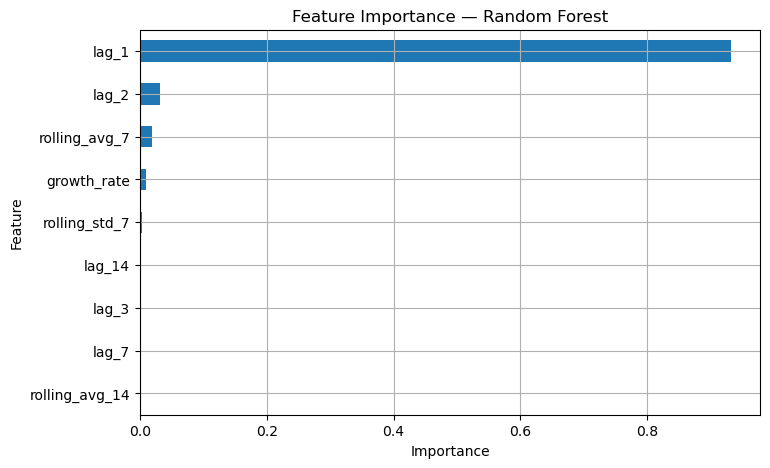

In [9]:
#Model Insight(Feature Importance)


importance = pd.Series(model.feature_importances_, index=features)
importance = importance.sort_values(ascending=True)

plt.figure(figsize=(8,5))
importance.plot(kind="barh")
plt.title("Feature Importance — Random Forest")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.grid(True)
plt.show()


In [10]:
#Forecasting

#Forecast Function (State)
def forecast_state(series,model,days=7):
    history = list(series.values[-14:])
    preds = []

    for _ in range(days):
        lag_1 = history[-1]
        lag_2 = history[-2]
        lag_3 = history[-3]
        lag_7 = history[-7]
        lag_14 = history[-14]

        rolling_avg_7 = np.mean(history[-7:])
        rolling_avg_14 = np.mean(history[-14:])
        rolling_std_7 = np.std(history[-7:])

        if history[-2] == 0:
            growth_rate = 0
        else:
            growth_rate = (history[-1] - history[-2]) / history[-2]

        growth_rate = max(min(growth_rate, 0.20), -0.20)

        features_vec = pd.DataFrame([[
    lag_1, lag_2, lag_3, lag_7, lag_14,
    rolling_avg_7, rolling_avg_14,
    rolling_std_7,
    growth_rate
]], columns=features)


        next_pred = model.predict(features_vec)[0]

        max_allowed = lag_1 * 1.25
        min_allowed = lag_1 * 0.75
        next_pred = max(min(next_pred, max_allowed), min_allowed)
        next_pred = max(next_pred, 0)

        preds.append(float(next_pred))
        history.append(next_pred)

    return preds


In [11]:
#Run forecast per state
state_forecasts = {}

for st in states:
    series = df_confirmed[st].fillna(0)
    state_forecasts[st] = forecast_state(series, model, days=7)


In [12]:
#Healthcare Stress Modeling

state_beds = {
    "TN": 120000,
    "KA": 110000,
    "MH": 250000,
    "DL": 75000,
    "KL": 90000
}

def stress_level(s):
    if s < 0.001:
        return "Very Low"
    elif s < 0.005:
        return "Low"
    elif s < 0.02:
        return "Rising"
    elif s < 0.05:
        return "High"
    else:
        return "Critical"


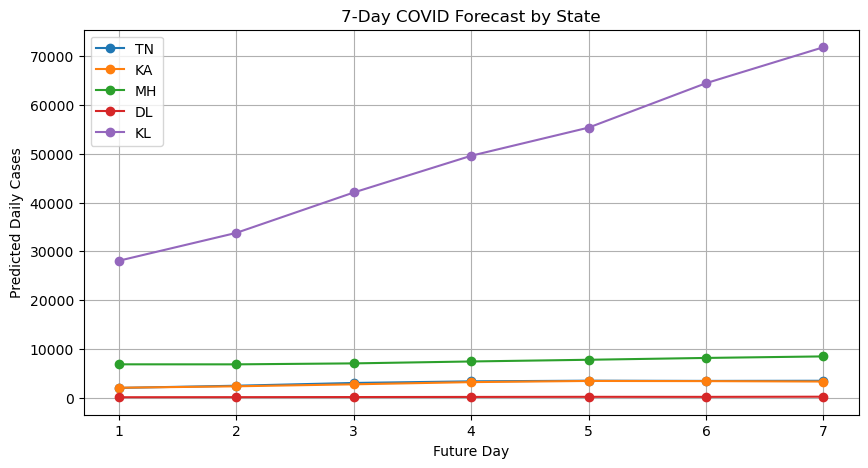

In [13]:
#Visualization

plt.figure(figsize=(10,5))

for st in states:
    preds = state_forecasts[st]
    plt.plot(range(1, len(preds)+1), preds, marker='o', label=st)

plt.title("7-Day COVID Forecast by State")
plt.xlabel("Future Day")
plt.ylabel("Predicted Daily Cases")
plt.legend()
plt.grid(True)
plt.show()


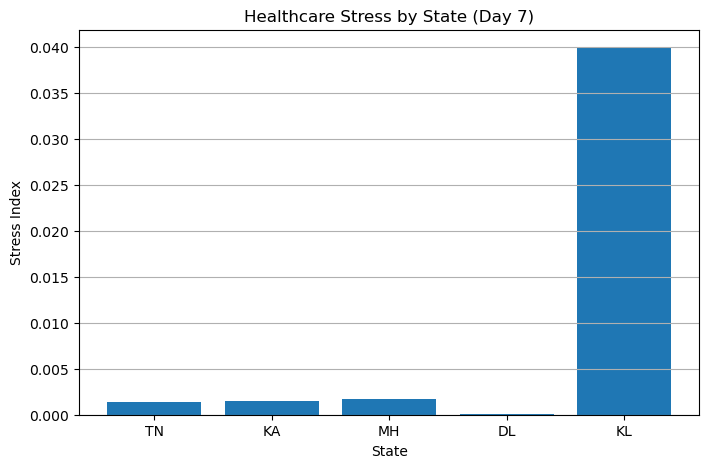

In [14]:
day7_stress = []
labels = []

for st in states:
    p = state_forecasts[st][-1]
    beds = state_beds[st]
    stress = (p * 0.05) / beds
    day7_stress.append(stress)
    labels.append(st)

plt.figure(figsize=(8,5))
plt.bar(labels, day7_stress)
plt.title("Healthcare Stress by State (Day 7)")
plt.xlabel("State")
plt.ylabel("Stress Index")
plt.grid(axis='y')
plt.show()


In [81]:
#save artifacts

joblib.dump(model, "covid_forecast_model.pkl")
df_state.to_csv("state_data.csv", index=False)
print("Artifacts saved")


Artifacts saved


In [75]:
#Limitations

Model trained on historical pandemic data; may not generalize to new patterns.
Recursive forecasting accumulates uncertainty.
Healthcare capacity values are approximate.
Model does not consider vaccination, policy, or mobility changes.
Forecast shows statistical trend, not exact case count.


SyntaxError: invalid syntax (941680927.py, line 3)